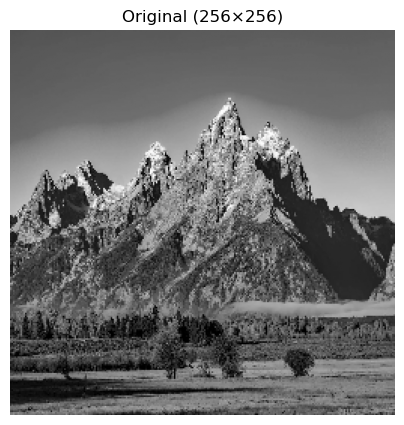

In [1]:
# %%
# Q11 — High-pass / sharpening in the frequency domain
import cv2
import numpy as np
import matplotlib.pyplot as plt

# --- load grayscale image (resize to 256×256 for consistency) ---
img_path = "../image2.jpg"  
img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
if img_gray is None:
    raise FileNotFoundError(img_path)
img_gray = cv2.resize(img_gray, (256, 256)).astype(np.float32)

plt.figure(figsize=(5,5))
plt.imshow(img_gray, cmap="gray")
plt.title("Original (256×256)")
plt.axis("off"); plt.show()


In [2]:
# %%
def fft2c(im):
    F  = np.fft.fft2(im)
    Fc = np.fft.fftshift(F)
    mag = np.log1p(np.abs(Fc))
    return Fc, mag

def ifft2c(Fc):
    F  = np.fft.ifftshift(Fc)
    im = np.fft.ifft2(F).real
    return im

def meshgrid_radius(shape):
    rows, cols = shape
    u = np.arange(rows) - rows//2
    v = np.arange(cols) - cols//2
    V, U = np.meshgrid(v, u)  # (row, col)
    R = np.sqrt(U**2 + V**2)
    return R


In [3]:
# %%
def ideal_lpf(shape, D0):
    R = meshgrid_radius(shape)
    return (R <= D0).astype(np.float32)

def gaussian_lpf(shape, D0):
    R = meshgrid_radius(shape)
    sigma = max(1e-6, D0/np.sqrt(2))
    return np.exp(-(R**2) / (2*sigma**2)).astype(np.float32)

def butterworth_lpf(shape, D0, n=2):
    R = meshgrid_radius(shape)
    eps = 1e-6
    return (1.0 / (1.0 + (R / max(D0,eps))**(2*n))).astype(np.float32)

def ideal_hpf(shape, D0):
    return 1.0 - ideal_lpf(shape, D0)

def gaussian_hpf(shape, D0):
    return 1.0 - gaussian_lpf(shape, D0)

def butterworth_hpf(shape, D0, n=2):
    return 1.0 - butterworth_lpf(shape, D0, n)


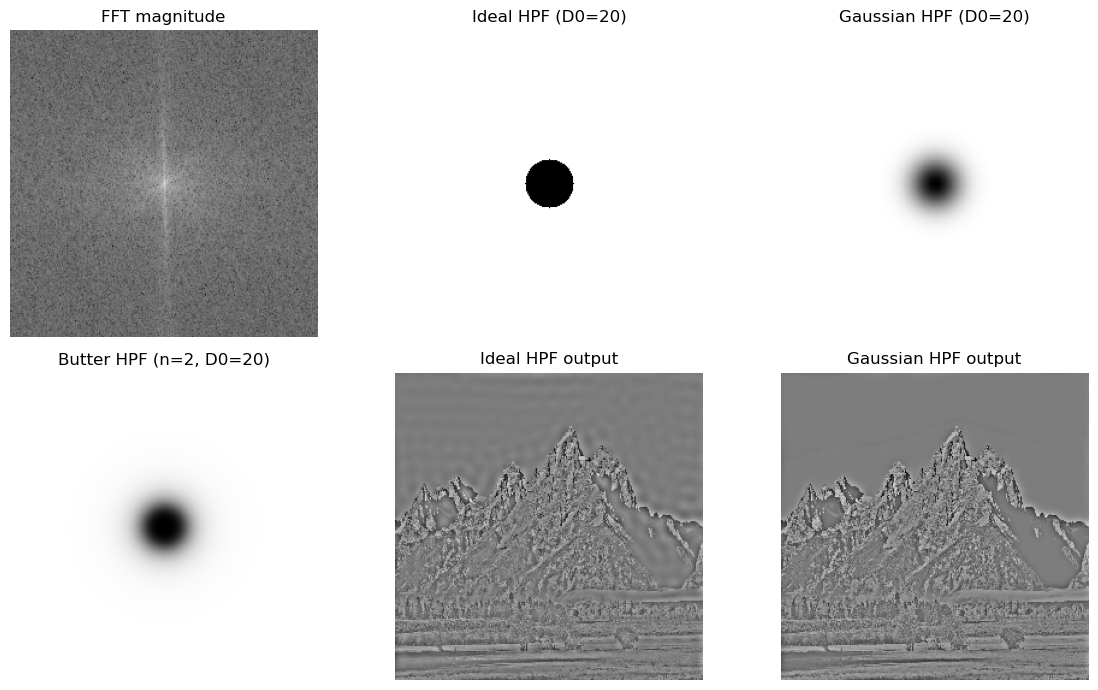

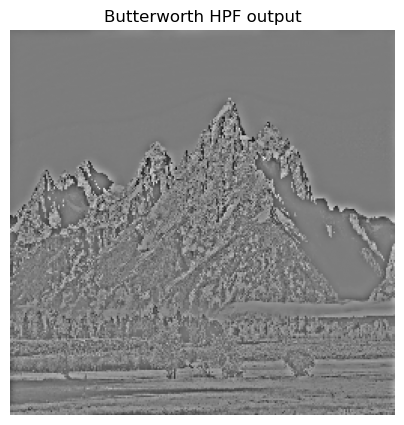

In [4]:
# %%
def apply_hpf(im, kind="gaussian", D0=20, order=2):
    Fc, mag = fft2c(im)
    if kind == "ideal":
        H = ideal_hpf(im.shape, D0)
    elif kind == "butter":
        H = butterworth_hpf(im.shape, D0, n=order)
    else:
        H = gaussian_hpf(im.shape, D0)
    Gc = Fc * H
    out = ifft2c(Gc)
    # HPF output has near-zero DC → may look dark; normalize to 0..255 for display
    out_n = out - out.min()
    out_n = (255.0 * out_n / (out_n.max() + 1e-8)).astype(np.uint8)
    return out_n, H, mag

# Quick demo
g20, Hg20, mag = apply_hpf(img_gray, "gaussian", D0=20)
i20, Hi20, _   = apply_hpf(img_gray, "ideal",    D0=20)
b20, Hb20, _   = apply_hpf(img_gray, "butter",   D0=20, order=2)

fig, ax = plt.subplots(2,3, figsize=(12,7))
ax[0,0].imshow(mag, cmap="gray"); ax[0,0].set_title("FFT magnitude"); ax[0,0].axis("off")
ax[0,1].imshow(Hi20, cmap="gray"); ax[0,1].set_title("Ideal HPF (D0=20)"); ax[0,1].axis("off")
ax[0,2].imshow(Hg20, cmap="gray"); ax[0,2].set_title("Gaussian HPF (D0=20)"); ax[0,2].axis("off")
ax[1,0].imshow(Hb20, cmap="gray"); ax[1,0].set_title("Butter HPF (n=2, D0=20)"); ax[1,0].axis("off")
ax[1,1].imshow(i20, cmap="gray");   ax[1,1].set_title("Ideal HPF output"); ax[1,1].axis("off")
ax[1,2].imshow(g20, cmap="gray");   ax[1,2].set_title("Gaussian HPF output"); ax[1,2].axis("off")
plt.tight_layout(); plt.show()

plt.figure(figsize=(5,5))
plt.imshow(b20, cmap="gray")
plt.title("Butterworth HPF output")
plt.axis("off"); plt.show()


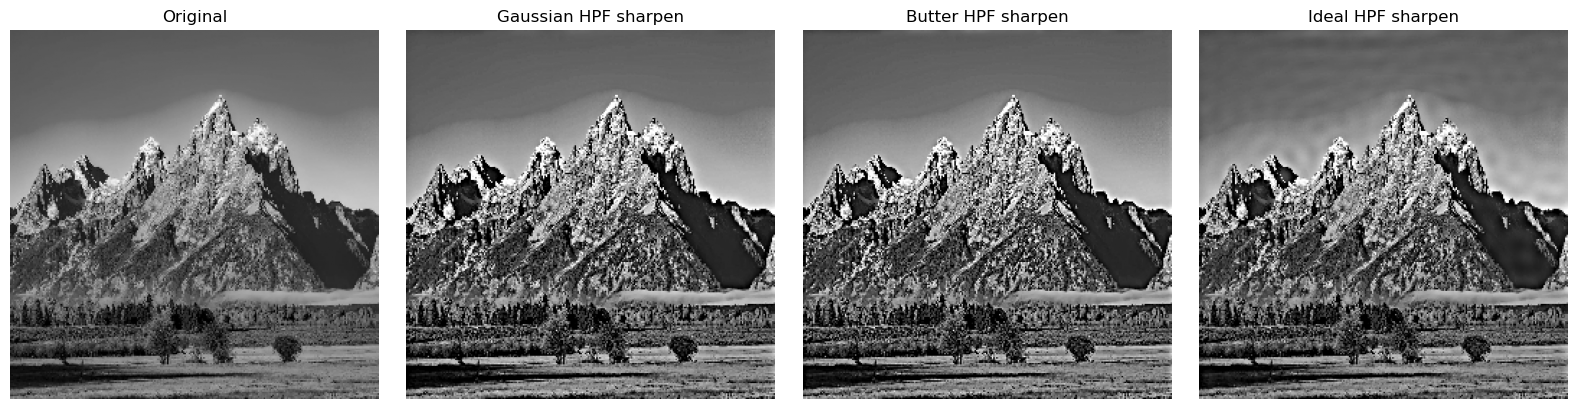

In [5]:
# %%
def sharpen_freq(im, method="gaussian", D0=20, order=2, k=1.0):
    """Return sharpened image using HPF boost (unsharp)."""
    # base image spectrum
    Fc, _ = fft2c(im)
    # pick HPF mask
    if method == "ideal":
        Hh = ideal_hpf(im.shape, D0)
    elif method == "butter":
        Hh = butterworth_hpf(im.shape, D0, order)
    else:
        Hh = gaussian_hpf(im.shape, D0)
    # high-frequency component
    Hc = Fc * Hh
    high = ifft2c(Hc)
    sharp = im + k * high
    # normalize to uint8 for display
    sharp = np.clip(sharp, 0, 255)
    return sharp.astype(np.uint8), Hh

sharp_g = sharpen_freq(img_gray, "gaussian", D0=20, k=1.0)[0]
sharp_b = sharpen_freq(img_gray, "butter",  D0=25, order=2, k=1.2)[0]
sharp_i = sharpen_freq(img_gray, "ideal",   D0=18, k=0.8)[0]

fig, ax = plt.subplots(1,4, figsize=(16,4))
ax[0].imshow(img_gray, cmap="gray"); ax[0].set_title("Original"); ax[0].axis("off")
ax[1].imshow(sharp_g, cmap="gray");  ax[1].set_title("Gaussian HPF sharpen"); ax[1].axis("off")
ax[2].imshow(sharp_b, cmap="gray");  ax[2].set_title("Butter HPF sharpen");   ax[2].axis("off")
ax[3].imshow(sharp_i, cmap="gray");  ax[3].set_title("Ideal HPF sharpen");    ax[3].axis("off")
plt.tight_layout(); plt.show()


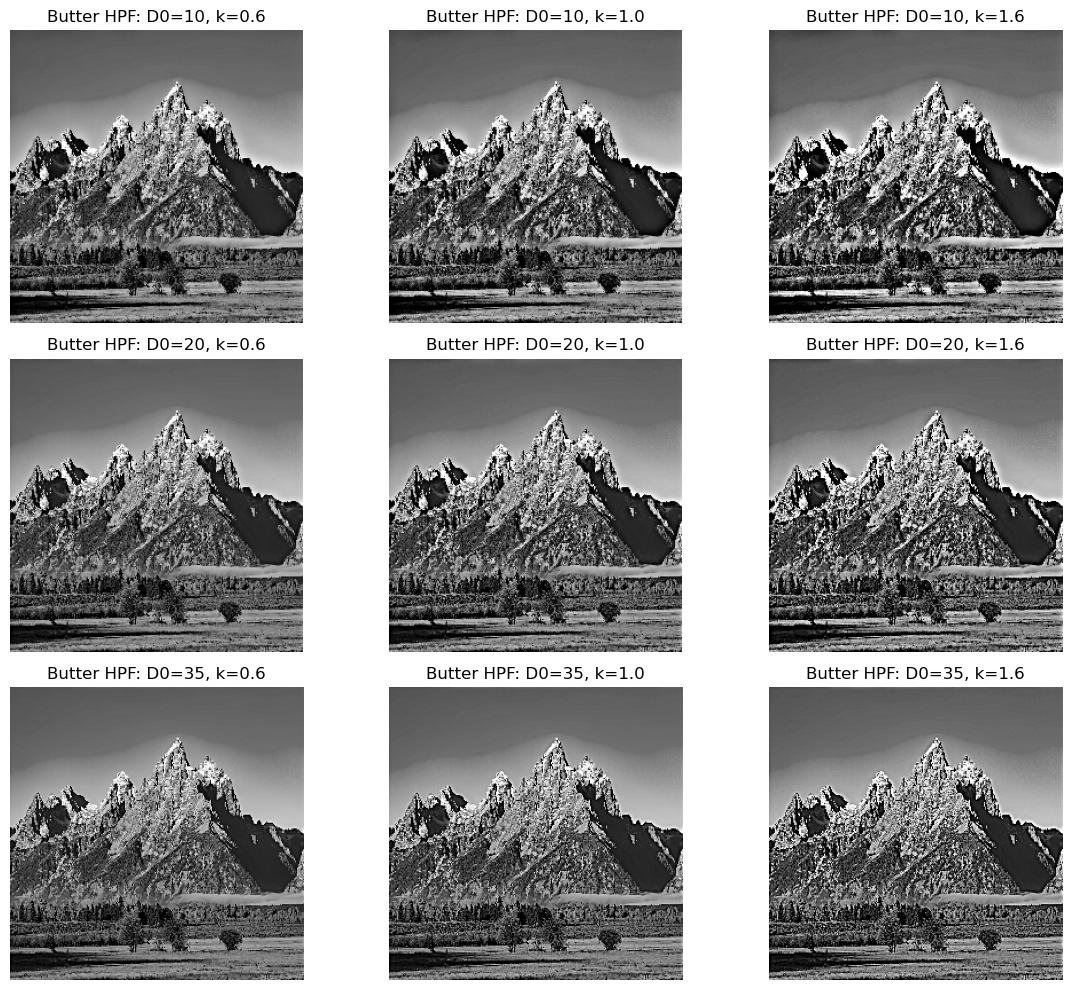

In [6]:
# %%
cutoffs = [10, 20, 35]
ks = [0.6, 1.0, 1.6]

fig, ax = plt.subplots(len(cutoffs), len(ks), figsize=(12,10))
for i, D0 in enumerate(cutoffs):
    for j, k in enumerate(ks):
        out, _ = sharpen_freq(img_gray, "butter", D0=D0, order=2, k=k)
        ax[i,j].imshow(out, cmap="gray")
        ax[i,j].set_title(f"Butter HPF: D0={D0}, k={k}")
        ax[i,j].axis("off")
plt.tight_layout(); plt.show()


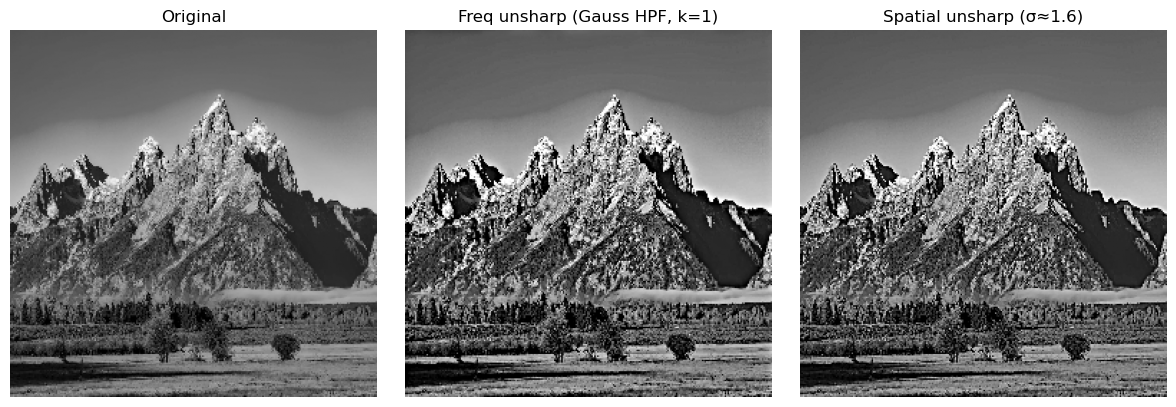

In [7]:
# %%
def gaussian_blur_spatial(im, sigma=1.6, ksize=7):
    im_u8 = im.astype(np.uint8)
    blur = cv2.GaussianBlur(im_u8, (ksize, ksize), sigmaX=sigma)
    return blur.astype(np.float32)

# Frequency-domain unsharp (Gaussian)
sharp_f, _ = sharpen_freq(img_gray, "gaussian", D0=20, k=1.0)

# Spatial-domain unsharp (original + k*(original - GaussianBlur(original)))
blur_s = gaussian_blur_spatial(img_gray, sigma=1.6, ksize=7)
unsharp_spatial = np.clip(img_gray + (img_gray - blur_s), 0, 255).astype(np.uint8)

fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(img_gray, cmap="gray");        ax[0].set_title("Original"); ax[0].axis("off")
ax[1].imshow(sharp_f, cmap="gray");         ax[1].set_title("Freq unsharp (Gauss HPF, k=1)"); ax[1].axis("off")
ax[2].imshow(unsharp_spatial, cmap="gray"); ax[2].set_title("Spatial unsharp (σ≈1.6)"); ax[2].axis("off")
plt.tight_layout(); plt.show()
